# Modelling of France Accidents

**Cohort:** mar23_accidents

**Author:** Tobias Schulze

**Date:** 14 September 2023



## Loading of required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import re
import pickle
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

## Importing the data

In [2]:
df = pd.read_csv('./data/231018_clean_table_for_analysis.csv', low_memory = False, index_col = 0)

## Data description
### Data

In [3]:
df.head()

place  catu  sexe  an_nais  trajet  locp    an  mois  jour  lum  \
Num_Acc                                                                         
201900000001    2.0     2     2     2002     0.0  -1.0  2019    11    30    4   
201900000001    1.0     1     2     1993     5.0  -1.0  2019    11    30    4   
201900000001    1.0     1     1     1959     0.0  -1.0  2019    11    30    4   
201900000002    1.0     1     2     1994     0.0  -1.0  2019    11    30    3   
201900000003    1.0     1     1     1996     0.0  -1.0  2019    11    28    1   

              ...  choc  manv        date  is_holiday  holiday  actp  num_veh  \
Num_Acc       ...                                                               
201900000001  ...   5.0  23.0  2019-11-30       False      NaN     0       14   
201900000001  ...   5.0  23.0  2019-11-30       False      NaN     0       14   
201900000001  ...   3.0  11.0  2019-11-30       False      NaN     0        0   
201900000002  ...   1.0   0.0  2019-11-30       False      NaN     0        0   
201900000003  ...   1.0   2.0  2019-11-28       False      NaN     1        0   

              hrmn  grav  etatp  
Num_Acc                          
201900000001    90     3      0  
201900000001    90     3      0  
201900000001    90     0      0  
201900000002   170     3      0  
201900000003   915     0      0  

[5 rows x 39 columns]

### Data types

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 39 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        object 
 32  is_holiday  bool   
 

### Missing data

In [5]:
df.isna().sum()

place               0
catu                0
sexe                0
an_nais             0
trajet              0
locp                0
an                  0
mois                0
jour                0
lum                 0
agg                 0
int                 0
atm                 0
col                 0
dep                 0
catr                0
circ                0
nbv                 0
vosp                0
prof                0
plan                0
surf                0
infra               0
situ                0
senc                0
catv                0
occutc              0
obs                 0
obsm                0
choc                0
manv                0
date                0
is_holiday          0
holiday       2367768
actp                0
num_veh             0
hrmn                0
grav                0
etatp               0
dtype: int64

This data has no missing values, accept the `holiday` variable which contains the name of the holiday or NaN.

### Drop variables
The dataset contains still some variables that represent information represented by other variables or are a finer granulation. The latter might be added later, if the primary variable is relevant.

- `holiday`: classifies the holiday, but will be used only, if `is_holiday` is relevant

In [6]:
columns_drop = ['holiday']

df.drop(columns = columns_drop, inplace = True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        object 
 32  is_holiday  bool   
 

## Data preparation
### Transform data types
#### Date and time variables
The date and time variables are maybe important as grouping variables or as contrains for time dependent severity of accidents.

_Problem_:

Due to the export to `csv`, the `datatime` data time is lost and thus, it is required to assign it again.

**Steps:**
1. Transform `date` and `hrmn` to `datetime` type.nais` to integer and `date` to `date`.

In [8]:
# Fixing the hrmn issue:
# Transform `date`
df = df.assign(date = pd.to_datetime(df['date']))
df = df.assign(hrmn = pd.to_datetime(df['hrmn']))

In [9]:
df['date'] = df.apply(lambda x: int(x['date'].timestamp()), axis = 1)
df['hrmn'] = df.apply(lambda x: int(x['hrmn'].timestamp()), axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        int64  
 32  is_holiday  bool   
 

## Data analysis
### Correlation matrix
To get a first glimpse on the possible contrains in the data, a correlation matrix is plotted.

The data variables are dropped to remove redundany with `timestamp`.

In [11]:
# Drop date columns for the correlation matrix
columns_drop = ['an', 'mois', 'jour', 'hrmn'] #, 'date']
df_select = df.drop(columns_drop, axis = 1)

In [12]:
# Scale the data
scaler = MinMaxScaler()
df_numeric_scaled = pd.DataFrame(scaler.fit_transform(df_select), columns=df_select.columns)

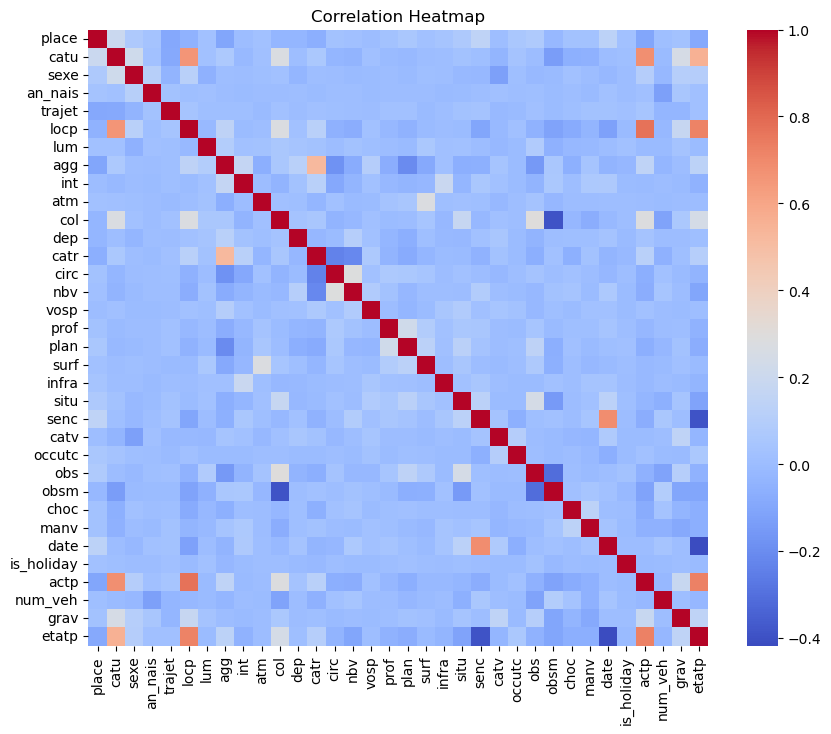

In [13]:
# Create a correlation matrix
correlation_matrix = df_numeric_scaled.corr()
plt.figure(figsize=(10, 8))
# Generate the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

# Add a title
plt.title('Correlation Heatmap')

# Display the plot
plt.show();

The correlation matrix shows some intervariable correlations, but no real importance of variables to predict the target `fatal`. 

### Preparation of the training and test datasets
#### Split data
The dataset is split by year slides. The years 2005 to 2019 are selected for the train dataset and the years 2020 and 2021 for the test dataset.

~In addition, the test dataset is split to a train and evaluation dataset with an evaluation set of 20% of the testing data.~

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2421684 entries, 201900000001 to 201800055766
Data columns (total 38 columns):
 #   Column      Dtype  
---  ------      -----  
 0   place       float64
 1   catu        int64  
 2   sexe        int64  
 3   an_nais     int64  
 4   trajet      float64
 5   locp        float64
 6   an          int64  
 7   mois        int64  
 8   jour        int64  
 9   lum         int64  
 10  agg         int64  
 11  int         int64  
 12  atm         float64
 13  col         float64
 14  dep         int64  
 15  catr        float64
 16  circ        float64
 17  nbv         float64
 18  vosp        float64
 19  prof        float64
 20  plan        float64
 21  surf        float64
 22  infra       float64
 23  situ        float64
 24  senc        float64
 25  catv        int64  
 26  occutc      float64
 27  obs         float64
 28  obsm        float64
 29  choc        float64
 30  manv        float64
 31  date        int64  
 32  is_holiday  bool   
 

In [15]:
# split the dataset to train and test data
X_train = df.loc[df['an'] < 2020].drop('grav', axis = 1)
X_test = df.loc[df['an'] > 2019].drop('grav', axis = 1)

y_train = df['grav'].loc[df['an'] < 2020]
y_test = df['grav'].loc[df['an'] > 2019]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

#split the train dataset to train and eval data
#X_test, X_eval, y_test, y_eval = train_test_split(X_train, y_train, test_size = 0.2, random_state = 123)

#### Data scaling
Decision trees are not sensitive to different scales and thus scaling is not required.

### Modelling the data using a XGBoost Classification Model with Tree-based Parzen Estimators optimisation
The Tree-based Parzen Estimator (TPE) [1] optimisation combines a Bayesian Sequential Model Based Optimisation (SMBO) and a random search on the hyperparemeter grid[2]. While the random search is a static approach, the SMBO optimises the model using prior runs to determine future points of exploration.

The package `hyperopt` [4] is used for optimisation. The hyperparameter optimisation code is written based on ideas in [5].

#### The tuning space
`hyperopt` uses a specific format of parameters expressions [7]. Hints on the parameter ranges are given in [1,5,7].

The `booster` in this first model is `gbtree`. The evaluation metric is `logloss` or `auc`[8].

In a later state, also Dropouts meet Multiple Additive Regression Trees (`dart`)[9] is tested.


In [16]:
# Create the tuning space
booster = 'gbtree'
eval_metric = 'auc'

tuning_space={
    'eta': hp.uniform('eta', 0, 1),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'gamma': hp.uniform ('gamma', 0, 10),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 100),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 10),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'colsample_bylevel' : hp.uniform('colsample_bylevel', 0, 1),
    'colsample_bynode' : hp.uniform('colsample_bynode', 0, 1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
    'seed': 123,
    'early_stopping_rounds': 10,
    'objective': 'binary:logistic',
    'subsample': hp.uniform('subsample', 0, 1)
    }

if (eval_metric == 'auc') or (eval_metric == 'logloss'):
    tuning_space.update({'scale_pos_weight': hp.uniform('scale_pos_weight', 0, 2)}) # helps in auc
    tuning_space.update({'max_delta_step': hp.uniform('max_delta_step', 0, 2)}) # helps in auc
    tuning_space.update({'eval_metric': eval_metric})
    tuning_space.update({'booster': booster})

if (booster == 'dart'):
    tuning_space.update({'rate_drop': hp.uniform('rate_drop', 0, 1)})
    tuning_space.update({'one_drop': 0})
    tuning_space.update({'skip_drop': hp.uniform('skip_drop', 0, 1)})

tuning_space

{'eta': <hyperopt.pyll.base.Apply at 0x7f2e84c5a010>,
 'max_depth': <hyperopt.pyll.base.Apply at 0x7f2e05d71390>,
 'gamma': <hyperopt.pyll.base.Apply at 0x7f2e05d71810>,
 'reg_alpha': <hyperopt.pyll.base.Apply at 0x7f2e05d71c90>,
 'reg_lambda': <hyperopt.pyll.base.Apply at 0x7f2e05d72110>,
 'colsample_bytree': <hyperopt.pyll.base.Apply at 0x7f2e05d72590>,
 'colsample_bylevel': <hyperopt.pyll.base.Apply at 0x7f2e05d72a10>,
 'colsample_bynode': <hyperopt.pyll.base.Apply at 0x7f2e05d72e90>,
 'min_child_weight': <hyperopt.pyll.base.Apply at 0x7f2e05d733d0>,
 'n_estimators': <hyperopt.pyll.base.Apply at 0x7f2e05d73910>,
 'seed': 123,
 'early_stopping_rounds': 10,
 'objective': 'binary:logistic',
 'subsample': <hyperopt.pyll.base.Apply at 0x7f2e05d73d90>,
 'scale_pos_weight': <hyperopt.pyll.base.Apply at 0x7f2e05d68210>,
 'max_delta_step': <hyperopt.pyll.base.Apply at 0x7f2e05d686d0>,
 'eval_metric': 'auc',
 'booster': 'gbtree'}

#### The tuning function

In [17]:
# Function for the classification
def hp_xgbclass(space, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    """ Function for Bayesian hyperparameter optimisation of XGboost classification model.
    Accepts a parameter `space` and the training and testing data set.
        :param tuning_space: a catalog containing the parameters used for hyperparameter tuning, ranges given in hp objects
        :param X_train: accepts the train data
        :param X_test: accepts the test data
        :param X_eval: accepts the eval data used for optimisation
        :param y_train: accepts the train target
        :param y_test: accepts the test target
        :param y_eval: accepts the eval data used for optimisation
    """

    if (space['objective'] == 'binary:logistic') and (space['booster'] == 'gbtree'):
        clf=xgb.XGBClassifier(
            eta = space['eta'],
            eval_metric = space['eval_metric'],
            booster = space['booster'],
            n_estimators = np.int64(space['n_estimators']),
            max_depth = np.int64(space['max_depth']),
            gamma = space['gamma'],
            reg_alpha = space['reg_alpha'],
            min_child_weight=np.int64(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            colsample_bylevel=space['colsample_bylevel'],
            colsample_bynode=space['colsample_bynode'],
            early_stopping_rounds = space['early_stopping_rounds'],
            objective = space['objective'],
            # scale_pos_weight = space['scale_pos_weight'],
            max_delta_step = space['max_delta_step'],
            subsample = space['subsample']
    
        )
            

    if (space['objective'] == 'binary:logistic') and (space['booster'] == 'dart'):
        clf=xgb.XGBClassifier(
            eta = space['eta'],
            eval_metric = space['eval_metric'],
            booster = space['booster'],
            n_estimators = np.int64(space['n_estimators']),
            max_depth = np.int64(space['max_depth']),
            gamma = space['gamma'],
            reg_alpha = space['reg_alpha'],
            min_child_weight=np.int64(space['min_child_weight']),
            colsample_bytree=space['colsample_bytree'],
            colsample_bylevel=space['colsample_bylevel'],
            colsample_bynode=space['colsample_bynode'],
            early_stopping_rounds = space['early_stopping_rounds'],
            objective = space['objective'],
            # scale_pos_weight = space['scale_pos_weight'],
            max_delta_step = space['max_delta_step'],
            subsample = space['subsample'],
            rate_drop = space['rate_drop'],
            one_drop = space['one_drop'],
            skip_drop = space['skip_drop']
        )
    

    clf.fit(X_train,
            y_train,
            eval_set = [(X_test, y_test)],
            verbose=False)
        
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Running the crossvalidation or load stored parameters

# Rerun or get stored parameters
cv_rerun = True

# define the stored files
# gbtree
if (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/161020_XGboost_gbtree_auc_hyperparameters_grav_raw_db'
    out_file_params = './data/XGboost_model/161020_XGboost_gbtree_auc_hyperparameters_grav_raw'
    
elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'gbtree'):
    out_file_trial = './data/XGboost_model/160923_XGboost_gbtree_lossless_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_gbtree_lossles_hyperparameters'

# dart
elif (tuning_space['eval_metric'] == 'auc') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_auc_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_auc_hyperparameters'

elif (tuning_space['eval_metric'] == 'lossless') and (tuning_space['booster'] == 'dart'):
    out_file_trial = './data/XGboost_model/160923_XGboost_dart_lossless_trial_db'
    out_file_params = './data/XGboost_model/160923_XGboost_dart_lossles_hyperparameters'


# rerun the crossvalidation
if (cv_rerun == True):
    trials = Trials()
    best_hyperparams = fmin(fn = hp_xgbclass,
                            space = tuning_space,
                            algo = tpe.suggest,
                            max_evals = 100,
                            trials = trials,
                            verbose=0
                           )
    # save the best parameters and the trials database
    with open(out_file_trial, 'wb') as f:
        pickle.dump(trials, f)

    with open(out_file_params, 'wb') as f:
        pickle.dump(best_hyperparams, f)

# get the stored hyperparameters
else:
    with open('./data/XGboost_model/161020_XGboost_gbtree_auc_hyperparameters_grav_raw', 'rb') as f:
        best_hyperparams = pickle.load(f)

SCORE: 0.35920456035188125
SCORE: 0.3623192336728282
SCORE: 0.3615010103475867
SCORE: 0.35969278200451155
SCORE: 0.3622469045391052
SCORE: 0.3604205939125993
SCORE: 0.3547698803404894
SCORE: 0.35809249992089
SCORE: 0.3615326543435905
SCORE: 0.360221688794861
SCORE: 0.36193950572078243
SCORE: 0.36147840749329824
SCORE: 0.359932372259969
SCORE: 0.35920456035188125
SCORE: 0.3623599188105474
SCORE: 0.36057429332176066
SCORE: 0.36063758131376833
SCORE: 0.35822811704662066
SCORE: 0.4062727441221277
SCORE: 0.36533445443490603
SCORE: 0.36115744696240243
SCORE: 0.3807496010596218
SCORE: 0.3676806307100461
SCORE: 0.38480907368982553
SCORE: 0.37583121996645735
SCORE: 0.40088874423062143
SCORE: 0.35999113968111895
SCORE: 0.39044170497850467
SCORE: 0.3571205771864871
SCORE: 0.3635623906586924
SCORE: 0.36174512117390184
SCORE: 0.3594757946033425
SCORE: 0.3614060783595752
SCORE: 0.3616637508984635
SCORE: 0.3625904679242895
SCORE: 0.3562209835858072
SCORE: 0.3613970372178599
SCORE: 0.3611258029663986


In [20]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bylevel': 0.43397539236588567, 'colsample_bynode': 0.09441498702102954, 'colsample_bytree': 0.8288661714915617, 'eta': 0.03487740894582859, 'gamma': 3.051542315176149, 'max_delta_step': 0.4994698047822773, 'max_depth': 4.0, 'min_child_weight': 6.0, 'n_estimators': 698.0, 'reg_alpha': 49.69843846467415, 'reg_lambda': 1.1348086402475026, 'scale_pos_weight': 1.494000772079216, 'subsample': 0.002045315249862123}


In [23]:
if (tuning_space['booster'] == "gbtree"):
     xgb_1 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree']
        
    )


if (tuning_space['booster'] == "dart"):
     xgb_1 = xgb.XGBClassifier(
        booster = tuning_space['booster'],
        eta = best_hyperparams['eta'],
        gamma = best_hyperparams['gamma'],
        max_depth = np.int64(best_hyperparams['max_depth']),
        min_child_weight = np.int64(best_hyperparams['min_child_weight']),
        reg_alpha = best_hyperparams['reg_alpha'],
        reg_lambda = best_hyperparams['reg_lambda'],
        eval_metric = tuning_space['eval_metric'],
        objective = tuning_space['objective'],
        seed = tuning_space['seed'],
        early_stopping_rounds = tuning_space['early_stopping_rounds'],
        n_estimators = np.int64(best_hyperparams['n_estimators']),
        subsample = best_hyperparams['subsample'],
        scale_pos_weight = best_hyperparams['scale_pos_weight'],
        max_delta_step = best_hyperparams['max_delta_step'],
        colsample_bylevel = best_hyperparams['colsample_bylevel'],
        colsample_bynode = best_hyperparams['colsample_bynode'],
        colsample_bytree = best_hyperparams['colsample_bytree'],
        rate_drop = best_hyperparams['rate_drop'],
        one_drop = space['one_drop'],
        skip_drop = best_hyperparams['skip_drop']
    )
  
xgb_1 = xgb_1.fit(X_train,
          y_train,
          eval_set = [(X_test, y_test)], 
          verbose = False)


[22:33:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1693020740964/work/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



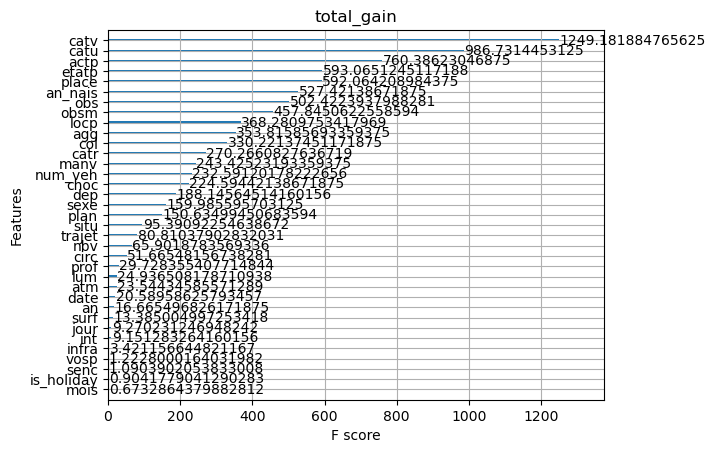

<Figure size 1600x1200 with 0 Axes>

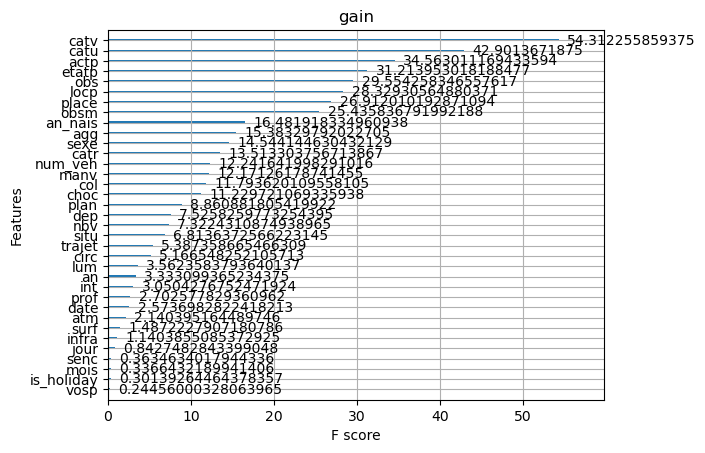

<Figure size 1600x1200 with 0 Axes>

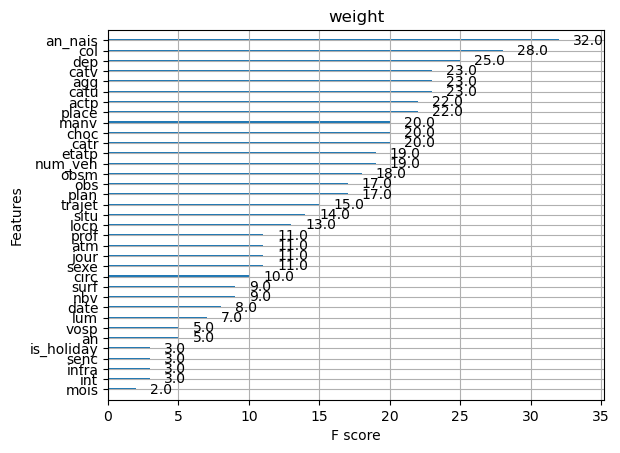

<Figure size 1600x1200 with 0 Axes>

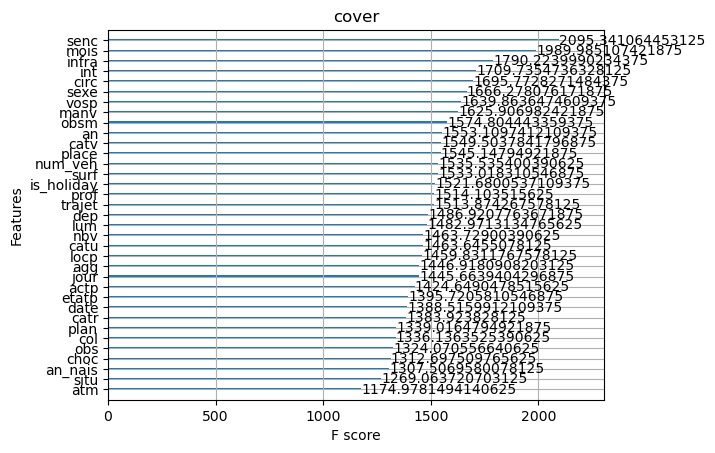

<Figure size 1600x1200 with 0 Axes>

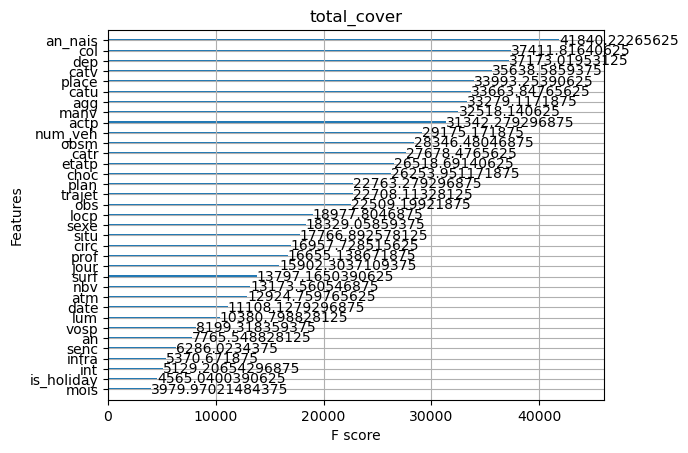

<Figure size 1600x1200 with 0 Axes>

In [24]:
importance_types = ['total_gain', 'gain', 'weight', 'cover', 'total_cover']

for f in importance_types:
    xgb.plot_importance(xgb_1, max_num_features=50, importance_type=f, title=f)
    plt.figure(figsize = (16, 12))
    plt.show();

In [25]:
y_pred = xgb_1.predict(X_test)
y_pred = [round(value) for value in y_pred]

print(classification_report(y_pred, y_test))

print(pd.crosstab(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.48      0.64    184134
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.24      0.58      0.34     37077

    accuracy                           0.50    221211
   macro avg       0.30      0.26      0.24    221211
weighted avg       0.84      0.50      0.59    221211

col_0      0     1      2      3
row_0                           
0      88711  3930  23513  67980
3       4180  1555   9932  21410


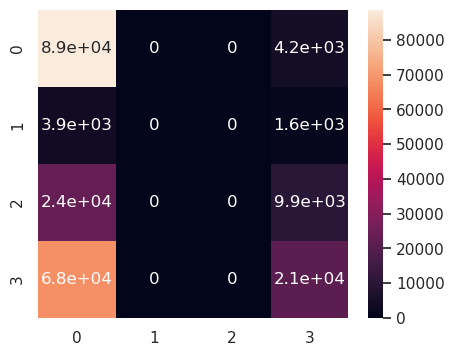

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (5, 4))
sns.set(font_scale=1)
sns.heatmap(cm, annot=True);

In [31]:
from xgboost import plot_tree
import graphviz
plot_tree(xgb_1)

ModuleNotFoundError: No module named 'graphviz'

## References
[1] [Bergstra, J., Yamins, D., Cox, D. D. (2013) Making a Science of Model Search: Hyperparameter Optimization in Hundreds of Dimensions for Vision Architectures. TProc. of the 30th International Conference on Machine Learning (ICML 2013), June 2013, pp. I-115 to I-23.](https://proceedings.neurips.cc/paper_files/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf)

[2] https://towardsdatascience.com/hyperopt-demystified-3e14006eb6fa

[3] https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html

[4] https://github.com/hyperopt/hyperopt

[5] https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning

[6] https://github.com/hyperopt/hyperopt/wiki/FMin

[7] https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html

[8] https://www.datamachines.io/blog/auc-vs-log-loss

[9] [Rashmi, K.V., Gilad-Bachrach (2015) DART: Dropouts meet Multiple Additive Regression Trees. arXiv:1505.01866v](https://doi.org/10.48550/arXiv.1505.01866)